In [1]:
#!pip install seaborn
#!pip install openpyxl
#!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import random as rd
import time
import csv
import seaborn as sbs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split ,GridSearchCV
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot
from pmdarima.arima import auto_arima
from pmdarima.arima import StepwiseContext
import pmdarima as pm
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
import yfinance as yf


In [3]:
# fix random seed for reproducibility
tf.random.set_seed(9)

In [4]:
path_name_results='../results/'
file_result = 'Result_ARIMA_TSLA_stock_prices.csv'

In [5]:
# Define the stock symbol (IBM)
stock_symbol = "TSLA"

# Define the start and end dates for the historical data
start_date = "2017-01-01"
end_date = "2023-09-21"

# Download historical data
dataset = yf.download(stock_symbol, start=start_date, end=end_date)

ds=pd.DataFrame()
ds['date']=dataset['Open'].index
ds['num_observations']=dataset['Open'].values
dataset=ds


[*********************100%%**********************]  1 of 1 completed


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690 entries, 0 to 1689
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              1690 non-null   datetime64[ns]
 1   num_observations  1690 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.5 KB


In [7]:
#verifica se existe variáveis nulas 
dataset.isna().sum()

date                0
num_observations    0
dtype: int64

In [8]:
def salvar_resultado(nm_dataset, ds_best_param, n_time_steps, MSE, RMSE, MAE, MAPE, sMAPE, Duration):
  #Script to write training cycle results
  data = [nm_dataset, ds_best_param, n_time_steps, MSE, RMSE, MAE, MAPE, sMAPE, Duration]
  fields = ['Dataset','Best Params','n_time_steps','MSE', 'RMSE', 'MAE', 'MAPE','sMAPE','Duration']
  with open(f'{path_name_results}{file_result}', "a",newline='') as csv_file:
    writer = csv.writer(csv_file,delimiter=';')
    writer.writerow(data)  
  print(fields)
  print(data)
    
#Script to create the results file
def criar_arquivo_resultado():
  fields = ['Dataset','Best Params','n_time_steps','MSE', 'RMSE', 'MAE','MAPE','sMAPE','Duration']
  with open(f'{path_name_results}{file_result}', "w",newline='') as csv_file:
    writer = csv.writer(csv_file,delimiter=';')
    writer.writerow(fields)    

In [9]:
# convert an array of values into a dataset matrix
def create_matrix_dataset(dataset, n_time_steps=1):
 #transformação da série => janela deslizande com n_time_steps passo de tempo    
 #tratando o dataframe
 df = pd.DataFrame()
 df['date']=dataset['date']
 df['vl_0']=dataset['num_observations']

 #n_time_steps=12
 for n_step in range(1,n_time_steps+1,1):   
   df['vl_' + str(n_step)] = dataset['num_observations'].shift(n_step)
 df.dropna(inplace=True)
 return np.array(df.drop(columns=['date','vl_0'])), np.array(df['vl_0'])

# convert dataset values into a dataset matrix
def create_dataset(dataset, n_time_steps=1):
 #transformação da série => janela deslizande com n_time_steps passo de tempo    
 #tratando o dataframe
 df = pd.DataFrame()
 df['date']=dataset['date']
 df['vl_0']=dataset['num_observations']

 #n_time_steps=12
 for n_step in range(1,n_time_steps+1,1):   
   df['vl_' + str(n_step)] = dataset['num_observations'].shift(n_step)
 df.dropna(inplace=True)
 return df

In [10]:
  
def save_model(model,n_time_steps):
  # serialize model to JSON
  model_json = model.to_json()
  with open(f'{path_name_results}model_{n_time_steps}.json', "w") as json_file:
    json_file.write(model_json)

  # serialize weights to HDF5
  model.save_weights(f'{path_name_results}model_{n_time_steps}.h5')
  print("Saved model to disk")


In [11]:
def gera_resultado(y_test, predict,nm_dataset, resultado, n_time_steps, Duracao):
 #Mean Squared Error (Mean Squared Difference Between Estimated Values and Actual Values) - MSE
 MSE = mean_squared_error(y_test, predict)    
 #Square Root of Mean Error - RMSE
 RMSE = np.sqrt(mean_squared_error(y_test, predict))    
 #Mean Absolute Distance or Mean Absolute Error - MAE
 MAE= median_absolute_error(y_pred=predict, y_true = y_test) 
  
 #Calculate the MAPE (Mean Absolute Percentage Error)
 MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100   
  
 sMAPE = round(
 	np.mean(
 		np.abs(predict - y_test) /
 		((np.abs(predict) + np.abs(y_test)))
 	)*100, 2
 ) 
 salvar_resultado(nm_dataset, resultado, n_time_steps, MSE, RMSE, MAE, MAPE, sMAPE, Duracao)
 return MAPE

array([<AxesSubplot:xlabel='date'>], dtype=object)

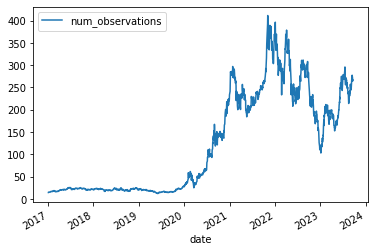

In [12]:
# indexing timestamp
dataset.set_index('date').plot(subplots=True)

In [13]:
def previsao_ARIMA(nm_dataset, dataset, n_time_steps, max_iter): 
    
 #Split dataset in treinam /  80% treinam  20% test
 nlinhas = int(len(dataset) * 0.80)
 test = dataset.iloc[nlinhas:len(dataset),:]  
 train = dataset.iloc[0:nlinhas,:] 
 #  reshape into X=t and Y=t+1 ot n_time_steps by steps
 X_train, Y_train = create_matrix_dataset(train, n_time_steps)
 X_test, Y_test = create_matrix_dataset(test, n_time_steps)  

 # indexing timeserires
 ts_df=create_dataset(dataset, n_time_steps)
 ts_df.set_index('date').plot(subplots=True) 

 Y_train = Y_train.reshape(-1,1)
 Y_test=Y_test.reshape(-1,1) 

 # Armazena a hora de início da execução do Treinamento
 Hora_Inicio = time.time() 

 # Estimate the differences number using ADF test
 # significance level alpha=0.05
 ADF_test = ADFTest(alpha=0.05)
 p_val, should_diff = ADF_test.should_diff(Y_train)   

 if(should_diff):  # if  should_diff is true 
     d = ndiffs(Y_train, test='adf') 
 else: # if  should_diff is False
     d=0 

 # autocorrelation test
 pm.plot_acf(Y_train) 

 # Search for best ARIMA hiperparams.
 with StepwiseContext(max_dur=50):
    model = auto_arima(Y_train, X = X_train,
                       seasonal=True, maxiter=500, d=d, 
                       start_p=0, start_q=0, max_p=9, max_q=9, 
                       D=None, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True) 

 #print(model.params)
 model.fit(Y_train)
 resultado = model 

 # predictiong values
 predict=model.predict(n_periods=Y_test.shape[0], X=X_test, alpha=0.05)
 predict=predict.reshape(-1,1) 

 Hora_Fim = time.time()    
 

 #print real x predict
 df_predict = pd.DataFrame(predict)
 new_df=pd.DataFrame()
 total=nlinhas+len(df_predict)
 new_df['real']=(dataset.iloc[0:total,1])
 new_df['date']=dataset.iloc[0:total,0]
 new_df['predict']=pd.concat([dataset.iloc[0:nlinhas,1],df_predict],ignore_index=True)
 new_df.set_index('date').plot() 

 #Calculate the duration of the training execution
 Duracao = Hora_Fim - Hora_Inicio    

 #calc metrics of error and save in file
 gera_resultado(Y_test, predict,nm_dataset, resultado, n_time_steps, Duracao)

forecast for TSLA stock prices


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


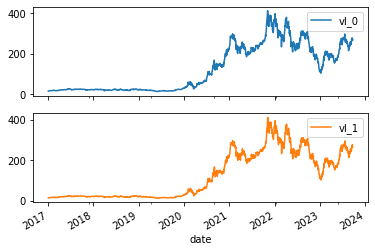

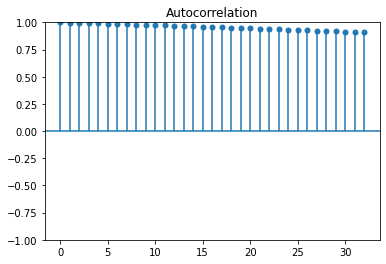

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8830.397, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8832.388, Time=1.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8832.383, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8829.651, Time=1.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8833.989, Time=8.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 11.820 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['TSLA', ARIMA(maxiter=500, order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 1, 3583.6706680051834, 59.86376757275793, 42.28666687011719, 27.11801247325678, 10.94, 14.885243892669678]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


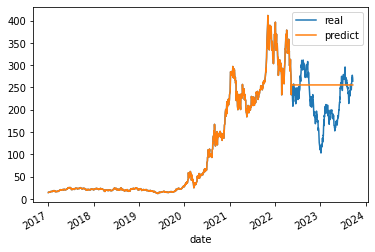

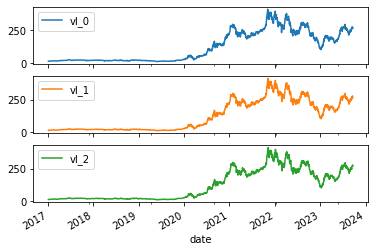

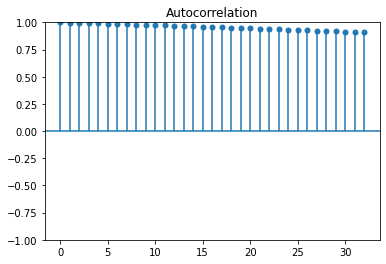

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8826.842, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8828.842, Time=0.99 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8828.842, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8826.081, Time=1.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8830.842, Time=1.68 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.792 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['TSLA', ARIMA(maxiter=500, order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 2, 3594.16685422562, 59.95137074517663, 42.78333282470703, 27.189670596119324, 10.97, 9.81119990348816]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


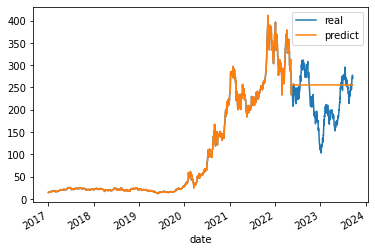

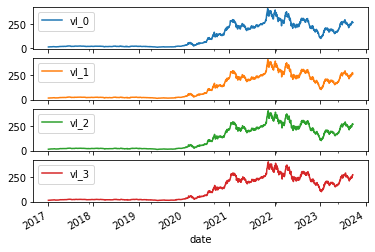

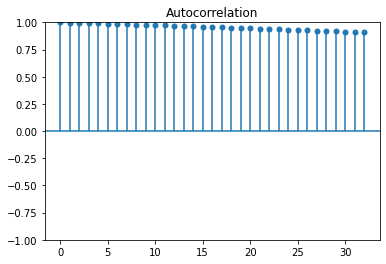

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8822.943, Time=0.71 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8823.945, Time=4.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8823.971, Time=5.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8822.223, Time=2.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8825.381, Time=5.98 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 18.467 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['TSLA', ARIMA(maxiter=500, order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 3, 3603.6953044688526, 60.030786305602, 43.279998779296875, 27.245433218935784, 10.99, 23.91665530204773]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


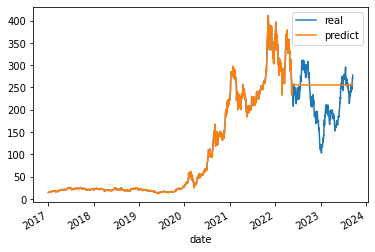

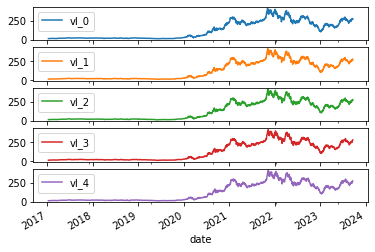

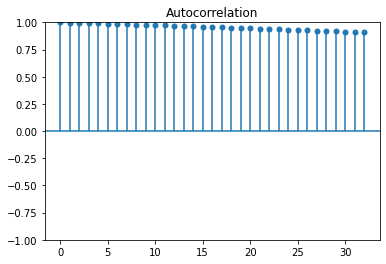

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8818.258, Time=0.99 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8819.983, Time=3.79 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8819.515, Time=4.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8817.457, Time=2.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8821.503, Time=11.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 22.711 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['TSLA', ARIMA(maxiter=500, order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 4, 3613.5443432770858, 60.11276356379805, 43.58499145507815, 27.304710323185414, 11.02, 29.86830759048462]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


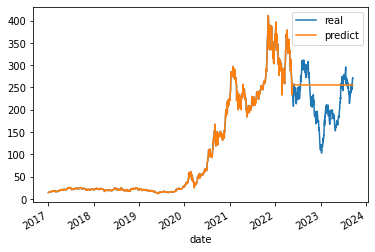

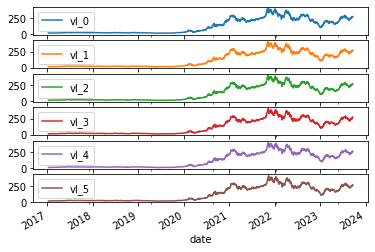

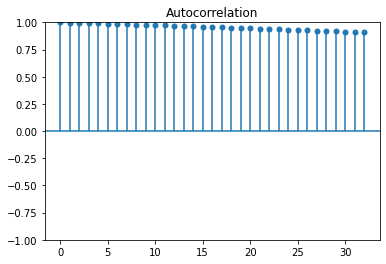

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8813.891, Time=0.89 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8814.322, Time=4.55 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8815.508, Time=4.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8813.154, Time=2.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8817.890, Time=3.55 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 16.597 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['TSLA', ARIMA(maxiter=500, order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 5, 3620.199837506028, 60.168096508914324, 43.8899841308594, 27.335294767219825, 11.02, 22.820738077163696]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


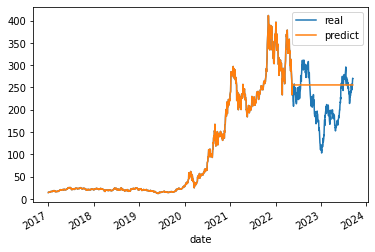

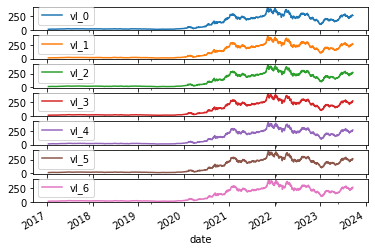

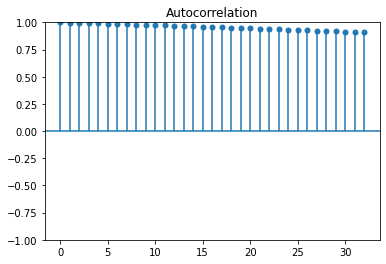

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8808.426, Time=0.85 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8808.602, Time=5.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8809.298, Time=4.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8807.580, Time=3.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8810.429, Time=8.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 21.650 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['TSLA', ARIMA(maxiter=500, order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 6, 3626.782844197997, 60.22277678916837, 43.92499542236328, 27.36525917585079, 11.03, 27.18254828453064]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


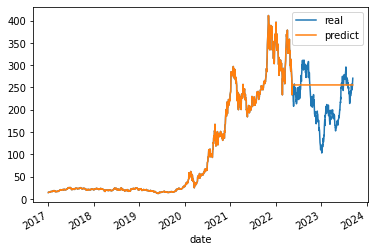

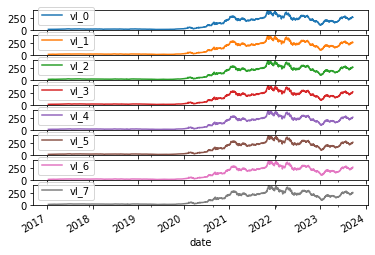

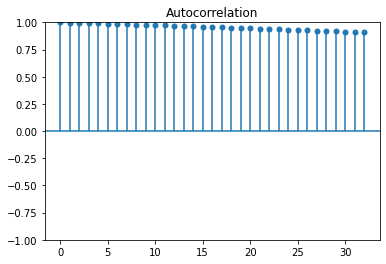

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8802.384, Time=0.89 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8804.289, Time=4.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8804.332, Time=5.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8801.414, Time=3.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8806.279, Time=10.63 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 23.978 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['TSLA', ARIMA(maxiter=500, order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 7, 3630.8457128868376, 60.25649934145559, 43.8899841308594, 27.37853225303088, 11.04, 31.720552444458008]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


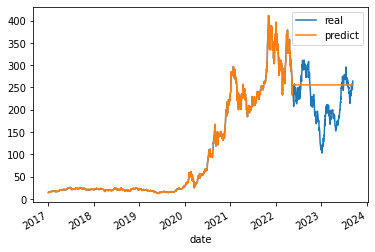

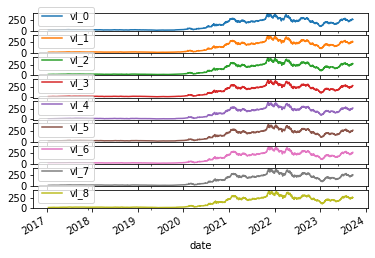

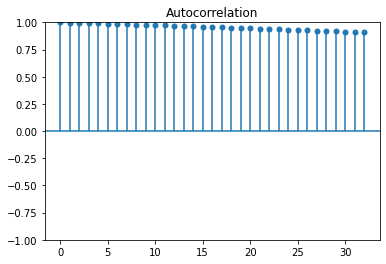

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8798.697, Time=2.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8800.210, Time=13.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8800.660, Time=7.87 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8797.698, Time=4.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8801.502, Time=13.97 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 41.841 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['TSLA', ARIMA(maxiter=500, order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 8, 3638.083645353966, 60.31652879065543, 43.92499542236328, 27.413052593814648, 11.05, 52.78342938423157]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


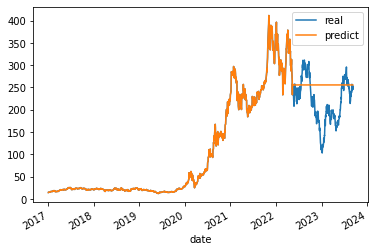

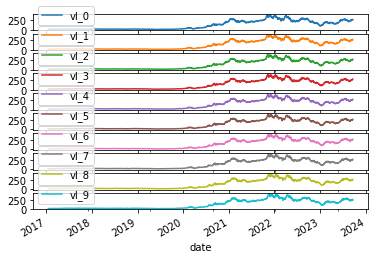

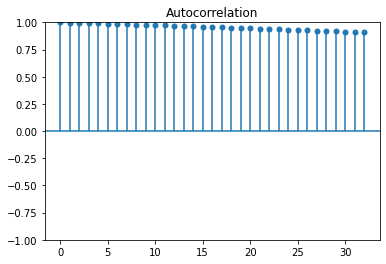

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8794.363, Time=1.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8791.657, Time=6.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8793.321, Time=7.75 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8793.422, Time=2.31 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8791.043, Time=22.81 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8788.799, Time=15.25 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 55.449 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (55.440 > 50.000)
  warnings.warn('early termination of stepwise search due to '


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['TSLA', ARIMA(maxiter=500, order=(3, 1, 0), scoring_args={}, suppress_warnings=True), 9, 7141.813109705024, 84.5092486637115, 65.69746629146294, 39.617365305612545, 15.07, 65.71160435676575]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


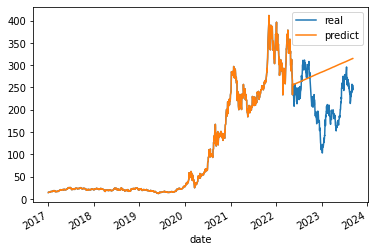

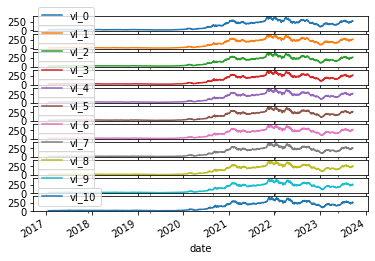

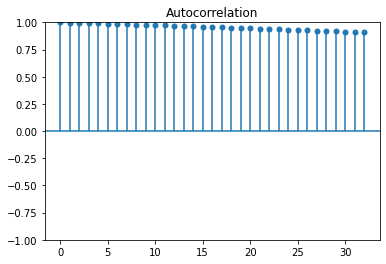

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8781.160, Time=2.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8783.031, Time=6.95 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8783.093, Time=6.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8780.449, Time=4.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8784.976, Time=11.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 31.206 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['TSLA', ARIMA(maxiter=500, order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 10, 3659.598819459757, 60.494618103264, 44.04999542236328, 27.55906379318871, 11.1, 44.49105453491211]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


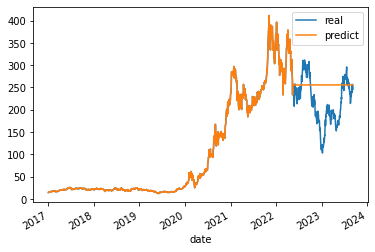

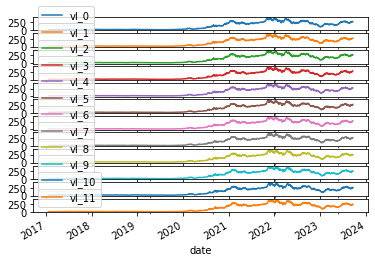

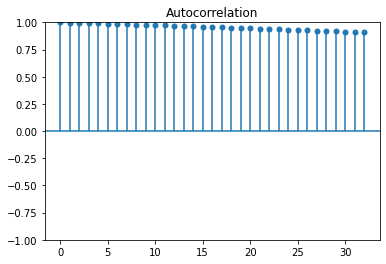

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8777.479, Time=1.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8777.488, Time=10.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8779.254, Time=5.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8776.792, Time=3.66 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8779.093, Time=12.62 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 33.064 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['TSLA', ARIMA(maxiter=500, order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 11, 3670.7413234948053, 60.586643111289845, 44.13998413085935, 27.6384827429849, 11.14, 41.978790521621704]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


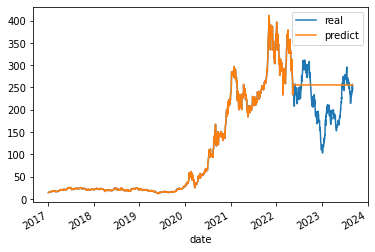

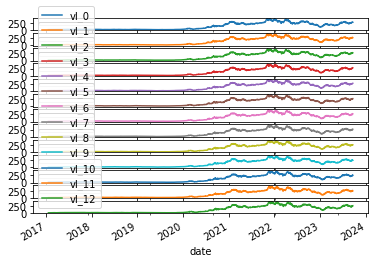

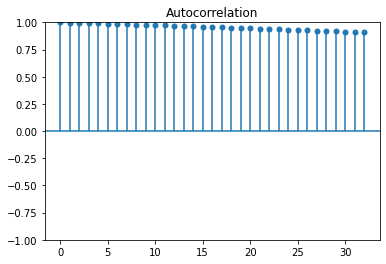

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8771.503, Time=1.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8772.779, Time=7.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8773.184, Time=6.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8770.686, Time=4.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8774.673, Time=21.70 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 41.177 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['TSLA', ARIMA(maxiter=500, order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 12, 3681.591110333049, 60.67611647372505, 44.24999237060547, 27.708735657374856, 11.16, 50.5607225894928]


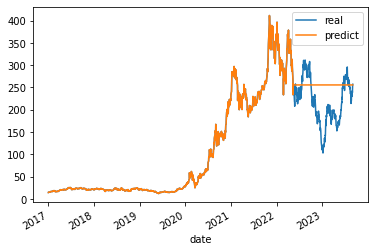

In [14]:
#create file to results
criar_arquivo_resultado()

print('forecast for TSLA stock prices')
max_iter =500 # number of epochs for train


for n_time_steps in range(1,13): #predict with 1 to 12 past values of medition 
   previsao_ARIMA('TSLA', dataset, n_time_steps, max_iter)